<a href="https://colab.research.google.com/github/Patrick-Nydegger/Cracks_in_concrete/blob/main/Cracks_in_concrete_%5Bmodel%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Project: Concrete Crack Detection with CNNs

**Team members:** Oliver, Patrick  
**Date:** 15.11.2025

## 0. Setup and Data Download

In this section, we set up our working environment. We import the necessary libraries, ensure that we are using a GPU runtime environment, and download the *Concrete Crack Images for Classification* dataset from Kaggle.

# Step 0: Setup and Environment Preparation

**Goal**: Import all necessary libraries, connect to Google Drive to access the data, and set up the environment (e.g., define constants and check for GPU availability). This ensures a reproducible and organized workflow.

In [1]:
# =============================================================================
# Step 0: Setup and Environment Configuration
# =============================================================================

# --- 1. Import Libraries ---
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import time
import random

# --- 2. Mount Google Drive ---
# This allows us to access files stored in your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

# --- 3. Configure Device (GPU or CPU) ---
# Check if a GPU is available and set the device accordingly.
# Training on a GPU is significantly faster.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

# --- 4. Define Constants and Paths ---
# Centralizing paths and constants makes the code cleaner and easier to modify.
DATASET_ZIP_PATH = "/content/drive/MyDrive/archive.zip"
EXTRACT_PATH = "/content/concrete_data"
POSITIVE_DIR_NAME = "Positive"
NEGATIVE_DIR_NAME = "Negative"

# --- 5. Unzip the Dataset ---
# We'll unzip the data into the Colab runtime's local storage for faster access.
# This only needs to be done once per session.
if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset...")
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Verify extraction
print("Contents of extracted directory:")
!ls {EXTRACT_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Device name: Tesla T4
Extracting dataset...
Extraction complete.
Contents of extracted directory:
Negative  Positive


# 1. 1. Dataset Analysis (15 Points)

Goal: Understand the dataset's structure, size, and characteristics. We will describe the data, visualize sample images, analyze the class distribution, and discuss any potential imbalances. This is a critical first step before any modeling.

In [2]:
# =============================================================================
# 1. Dataset Analysis (15 Points)
# =============================================================================

# --- 1.1. Load File Paths and Labels ---
# We create a list of all image paths and their corresponding labels (0 for Negative, 1 for Positive).
positive_path = os.path.join(EXTRACT_PATH, POSITIVE_DIR_NAME)
negative_path = os.path.join(EXTRACT_PATH, NEGATIVE_DIR_NAME)

positive_files = [(os.path.join(positive_path, f), 1) for f in os.listdir(positive_path) if f.endswith('.jpg')]
negative_files = [(os.path.join(negative_path, f), 0) for f in os.listdir(negative_path) if f.endswith('.jpg')]

all_files = positive_files + negative_files
random.shuffle(all_files) # Shuffle to ensure randomness

# Create a DataFrame for easier analysis
df = pd.DataFrame(all_files, columns=['filepath', 'label'])
df['label_name'] = df['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

print(f"Total images found: {len(df)}")
df.head()

Total images found: 40000


,filepath,label,label_name
0,/content/concrete_data/Positive/13293_1.jpg,1,Positive
1,/content/concrete_data/Positive/13130_1.jpg,1,Positive
2,/content/concrete_data/Negative/04217.jpg,0,Negative
3,/content/concrete_data/Negative/19173.jpg,0,Negative
4,/content/concrete_data/Positive/18667_1.jpg,1,Positive


--- Class Distribution ---
label_name
Positive    20000
Negative    20000
Name: count, dtype: int64


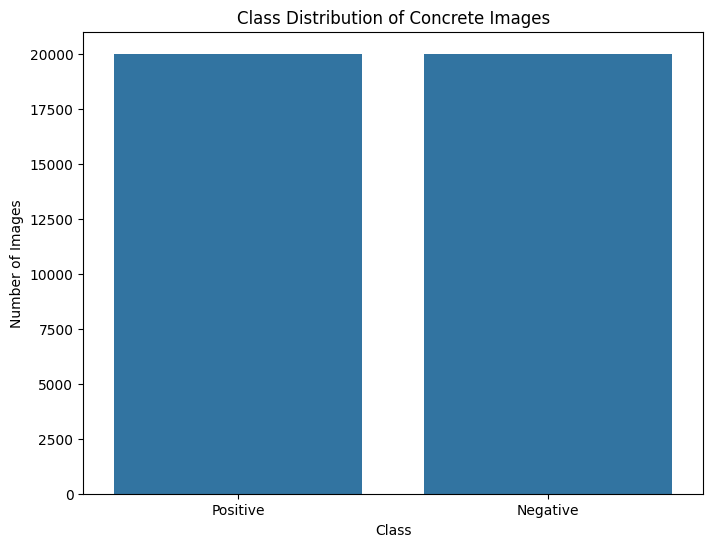

In [3]:
# --- 1.2. Class Distribution Analysis ---
# We check if the dataset is balanced, which is crucial for training an unbiased model.
print("--- Class Distribution ---")
class_counts = df['label_name'].value_counts()
print(class_counts)

# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of Concrete Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Discussion of Imbalance (for the journal)
# The output shows 20,000 images for 'Positive' and 20,000 for 'Negative'.
# This is a perfectly balanced dataset. This is excellent because it means we
# don't have to worry about the model being biased towards one class.
# Standard accuracy will be a meaningful metric, although we will also look at others.

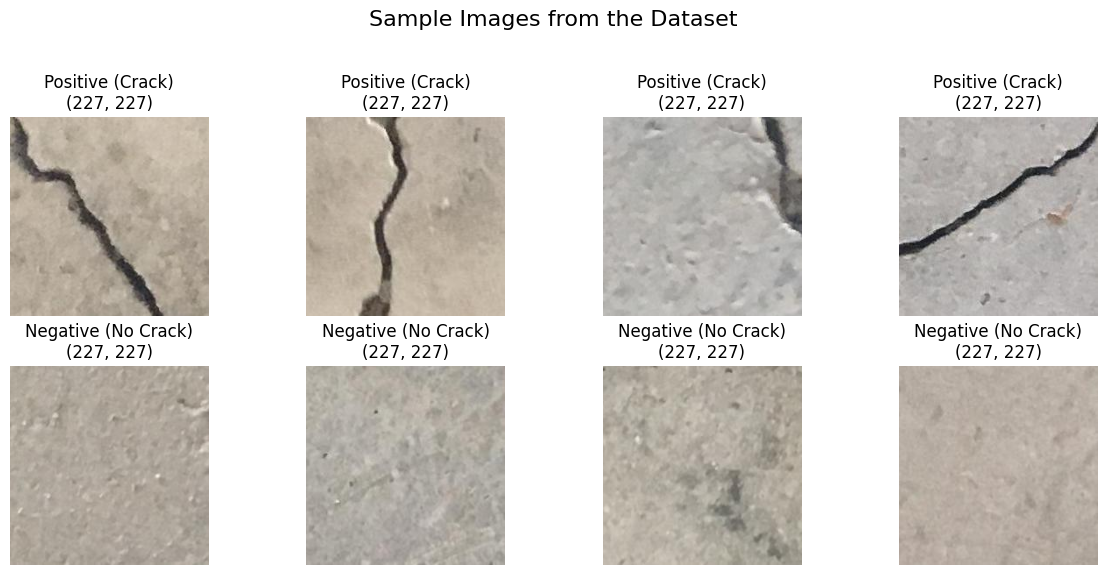

In [4]:
# --- 1.3. Image Visualization ---
# Let's look at some examples to get a feel for the data.
def show_sample_images(df, n_samples=4):
    positive_samples = df[df['label'] == 1].sample(n_samples)
    negative_samples = df[df['label'] == 0].sample(n_samples)

    plt.figure(figsize=(12, 6))
    for i, row in enumerate(positive_samples.itertuples()):
        plt.subplot(2, n_samples, i + 1)
        img = Image.open(row.filepath)
        plt.imshow(img)
        plt.title(f"Positive (Crack)\n{img.size}")
        plt.axis('off')

    for i, row in enumerate(negative_samples.itertuples()):
        plt.subplot(2, n_samples, i + 1 + n_samples)
        img = Image.open(row.filepath)
        plt.imshow(img)
        plt.title(f"Negative (No Crack)\n{img.size}")
        plt.axis('off')

    plt.suptitle("Sample Images from the Dataset", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

show_sample_images(df)

# Observations (for the journal)
# - The images have a resolution of 227x227 pixels and are in RGB format.
# - There is variance in lighting conditions and surface textures, as described on Kaggle.
# - Some cracks are very fine and subtle, while others are large and obvious.
# - Some 'Negative' images have shadows or stains that could potentially be confused for cracks.
#   This will be a challenge for our model.

# 2. Data Preparation & Splitting (10 Points)

**Goal**: Split the dataset into three distinct sets: training, validation, and testing. We will use a stratified split to ensure that the class distribution is maintained across all sets. This is fundamental for robust model training and unbiased evaluation. First, we will create the necessary directory structure for our splits.

In [5]:
# =============================================================================
# 2. Data Preparation & Splitting (10 Points)
# =============================================================================

# --- 2.1. Define and Create Directory Structure ---
# It's good practice to organize our data into train, validation, and test folders.
# This structure is also compatible with PyTorch's ImageFolder dataset class.

SPLIT_DIR = "/content/split_data"
TRAIN_DIR = os.path.join(SPLIT_DIR, "train")
VAL_DIR = os.path.join(SPLIT_DIR, "val")
TEST_DIR = os.path.join(SPLIT_DIR, "test")

# Create directories if they don't exist
if not os.path.exists(SPLIT_DIR):
    os.makedirs(os.path.join(TRAIN_DIR, POSITIVE_DIR_NAME))
    os.makedirs(os.path.join(TRAIN_DIR, NEGATIVE_DIR_NAME))
    os.makedirs(os.path.join(VAL_DIR, POSITIVE_DIR_NAME))
    os.makedirs(os.path.join(VAL_DIR, NEGATIVE_DIR_NAME))
    os.makedirs(os.path.join(TEST_DIR, POSITIVE_DIR_NAME))
    os.makedirs(os.path.join(TEST_DIR, NEGATIVE_DIR_NAME))
    print("Directory structure created.")
else:
    print("Directory structure already exists.")

# --- 2.2. Stratified Splitting of the DataFrame ---
# We use the DataFrame created in the analysis step to perform the split.
# Split Ratio: 70% Training, 15% Validation, 15% Testing.

# First, separate features (filepaths) and labels for scikit-learn
X = df['filepath']
y = df['label']

# Split 1: Create training set (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split 2: Split the temporary set into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# --- 2.3. Copy Files into the New Directory Structure ---
# This function copies the files from the original location to the new split directories.
import shutil

def copy_files(filepaths, labels, destination_dir):
    for filepath, label in zip(filepaths, labels):
        filename = os.path.basename(filepath)
        if label == 1: # Positive
            dest_path = os.path.join(destination_dir, POSITIVE_DIR_NAME, filename)
        else: # Negative
            dest_path = os.path.join(destination_dir, NEGATIVE_DIR_NAME, filename)
        shutil.copyfile(filepath, dest_path)

# Check if files have already been copied to avoid re-copying on re-runs
if len(os.listdir(os.path.join(TRAIN_DIR, POSITIVE_DIR_NAME))) == 0:
    print("Copying files to split directories...")
    copy_files(X_train, y_train, TRAIN_DIR)
    copy_files(X_val, y_val, VAL_DIR)
    copy_files(X_test, y_test, TEST_DIR)
    print("File copying complete.")
else:
    print("Files already copied to split directories.")

# --- 2.4. Verify Splits and Final File Counts ---
print("\n--- Final File Count Verification ---")
print(f"Training - Positive: {len(os.listdir(os.path.join(TRAIN_DIR, POSITIVE_DIR_NAME)))}")
print(f"Training - Negative: {len(os.listdir(os.path.join(TRAIN_DIR, NEGATIVE_DIR_NAME)))}")
print(f"Total Training: {len(X_train)}")

print(f"\nValidation - Positive: {len(os.listdir(os.path.join(VAL_DIR, POSITIVE_DIR_NAME)))}")
print(f"Validation - Negative: {len(os.listdir(os.path.join(VAL_DIR, NEGATIVE_DIR_NAME)))}")
print(f"Total Validation: {len(X_val)}")

print(f"\nTest - Positive: {len(os.listdir(os.path.join(TEST_DIR, POSITIVE_DIR_NAME)))}")
print(f"Test - Negative: {len(os.listdir(os.path.join(TEST_DIR, NEGATIVE_DIR_NAME)))}")
print(f"Total Test: {len(X_test)}")

# Let's also check the proportions from the dataframes again to be sure
print("\n--- Class Distribution in DataFrames (as percentage) ---")
print("Training set distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation set distribution:\n", y_val.value_counts(normalize=True))
print("\nTest set distribution:\n", y_test.value_counts(normalize=True))

Directory structure created.
Copying files to split directories...
File copying complete.

--- Final File Count Verification ---
Training - Positive: 14000
Training - Negative: 14000
Total Training: 28000

Validation - Positive: 3000
Validation - Negative: 3000
Total Validation: 6000

Test - Positive: 3000
Test - Negative: 3000
Total Test: 6000

--- Class Distribution in DataFrames (as percentage) ---
Training set distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Validation set distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64

Test set distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


### **4. Data Augmentation Strategy (10 Points)**

**Goal:** Define and implement a data augmentation strategy to artificially increase the diversity of our training dataset. This helps the model generalize better to new, unseen images and makes it more robust against variations in real-world conditions. We will carefully select techniques relevant to crack detection and visualize their combined effect.

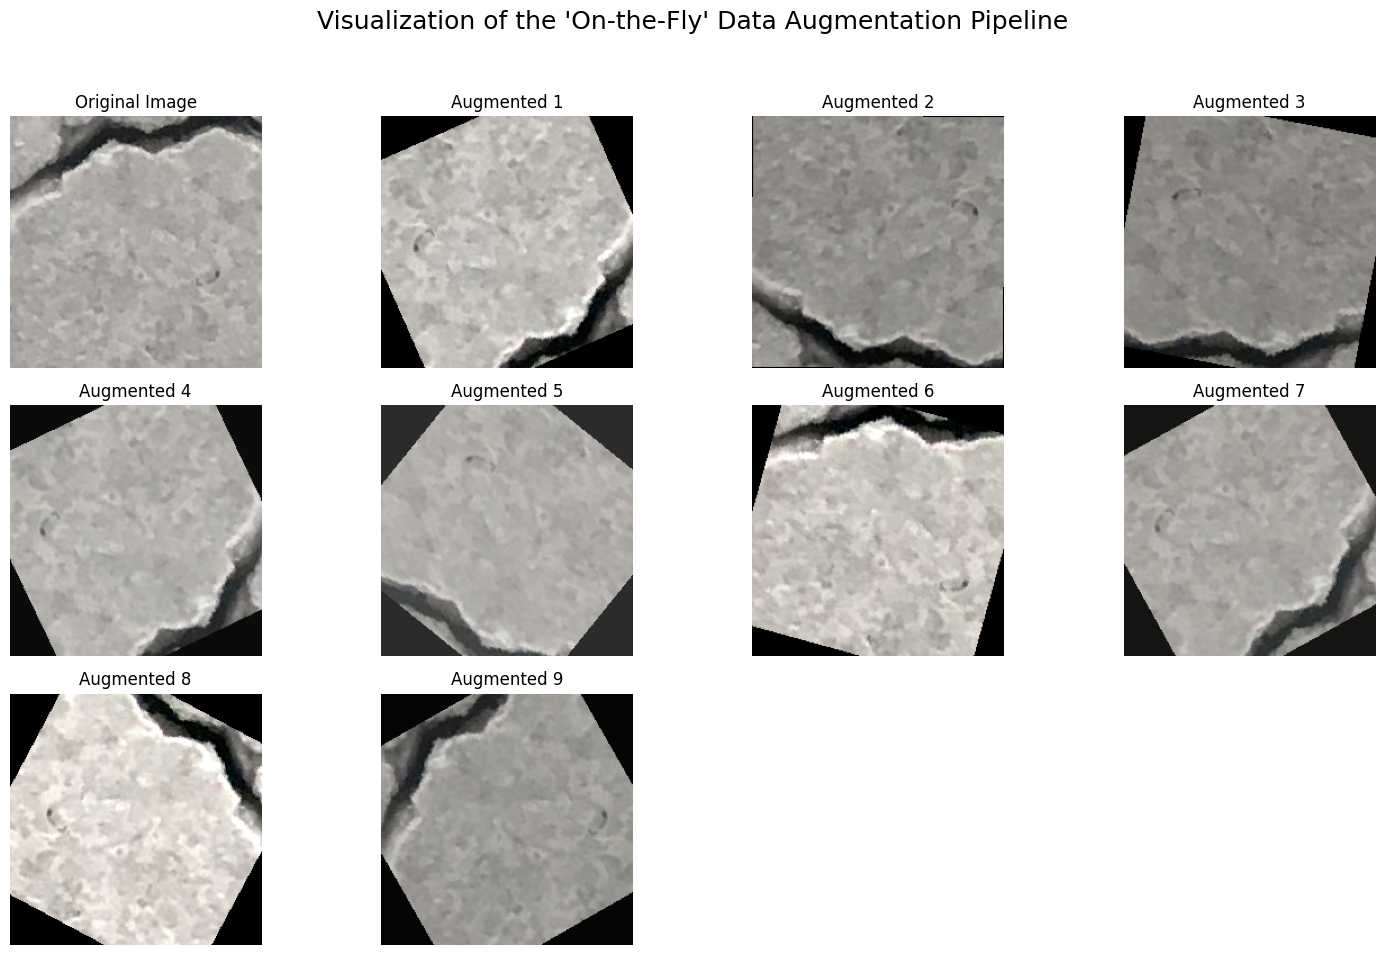

In [6]:
# =============================================================================
# 4. Data Augmentation Strategy (10 Points)
# =============================================================================

# --- 4.1. Define and Justify Augmentation Choices ---
# Based on the nature of concrete cracks, we select augmentations that simulate
# real-world inspection scenarios. This is done "on-the-fly" during training.

IMG_SIZE = 224

# Define the comprehensive transformation pipeline for the training set
train_transforms = transforms.Compose([
    # --- Geometric Augmentations ---
    # RandomResizedCrop is a powerful augmentation. It randomly crops a part of the
    # image and resizes it to IMG_SIZE. The `scale` parameter controls the zoom.
    # It effectively simulates both zooming and shifting (translation).
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),

    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),

    # --- Color Augmentations ---
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),

    # --- Final Preprocessing ---
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define the transformation pipeline for validation and test sets (NO augmentation)
# Note: Here we use a simple Resize, not RandomResizedCrop.
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# --- 4.2. Visualize the Combined Augmentation Effects ---
# This function demonstrates the power of applying multiple transformations simultaneously.
# (The visualization function from the previous step remains the same)

def visualize_augmentations(image_path, transform, num_augmented_images=9):
    """Applies and visualizes a chain of augmentations on a single image."""
    original_img = Image.open(image_path).convert("RGB")

    # Denormalization function for visualization
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(15, 10))

    # Original Image (resized)
    plt.subplot(3, 4, 1)
    plt.imshow(original_img.resize((IMG_SIZE, IMG_SIZE)))
    plt.title("Original Image")
    plt.axis('off')

    # Augmented Images
    for i in range(num_augmented_images):
        augmented_tensor = transform(original_img)
        # Denormalize and convert back to displayable format
        augmented_img_tensor = inv_normalize(augmented_tensor)
        augmented_img = transforms.ToPILImage()(augmented_img_tensor)

        plt.subplot(3, 4, i + 2)
        plt.imshow(augmented_img)
        plt.title(f"Augmented {i+1}")
        plt.axis('off')

    plt.suptitle("Visualization of the 'On-the-Fly' Data Augmentation Pipeline", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Select a sample image with a clear crack to visualize
sample_image_path = df[df['label'] == 1]['filepath'].iloc[0]
visualize_augmentations(sample_image_path, train_transforms)

### **5. Choice of Loss Function (5 Points)**

**Goal:** Select and justify the appropriate loss function for our binary classification task. The loss function quantifies how "wrong" the model's predictions are, and its minimization is the core objective of the training process.

### **6. Model Selection / Baseline Network (10 Points)**

**Goal:** Select a pre-existing, established neural network architecture to serve as our baseline. We must justify this choice based on its architectural advantages and suitability for our specific problem (crack detection).

In [7]:
# =============================================================================
# 6. Model Selection / Baseline Network (10 Points)
# =============================================================================

# --- 6.1. Define the Baseline Model Class ---
def get_mobilenetv2_baseline(pretrained=True):
    """
    Creates a MobileNetV2 model adapted for binary classification.
    Args:
        pretrained (bool): If True, use ImageNet weights.
    """
    # Load the standard MobileNetV2 architecture
    weights = models.MobileNet_V2_Weights.DEFAULT if pretrained else None
    model = models.mobilenet_v2(weights=weights)

    # --- 6.2. Adapt the Output Layer ---
    # MobileNetV2 uses a classifier block at the end. The final layer is called 'classifier[1]'.
    # We need to replace it to output 1 value (binary logit).

    # Get the number of input features to the final layer (usually 1280 for MobileNetV2)
    num_ftrs = model.classifier[1].in_features

    # Replace the final linear layer
    model.classifier[1] = nn.Linear(num_ftrs, 1)

    return model

# --- 6.3. Instantiate and Verify ---
baseline_model = get_mobilenetv2_baseline(pretrained=True)

# Move model to the configured device (GPU if available)
baseline_model = baseline_model.to(device)

print(f"Baseline Model (MobileNetV2) initialized on {device}.")
print("Output layer architecture:", baseline_model.classifier)

# Quick test with a dummy input to ensure shapes are correct
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = baseline_model(dummy_input)
print(f"Output shape for dummy input: {output.shape}") # Should be [1, 1]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 138MB/s]


Baseline Model (MobileNetV2) initialized on cuda.
Output layer architecture: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1, bias=True)
)
Output shape for dummy input: torch.Size([1, 1])


### **7. Custom Model Design (15 Points)**

**Goal:** Design and implement a custom Convolutional Neural Network architecture tailored specifically for the crack detection task. We aim to build a model that is more lightweight than the baseline while maintaining competitive accuracy.

In [8]:
# =============================================================================
# 7. Custom Model Design (15 Points)
# =============================================================================

class OPNet(nn.Module):
    def __init__(self):
        super(OPNet, self).__init__()

        # --- Block 1: Low-level Features (Edges) ---
        # Input: 3 channels (RGB), Output: 32 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Reduces size by half (112x112)
        )

        # --- Block 2: Mid-level Features (Textures) ---
        # Input: 32 channels, Output: 64 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Reduces size by half (56x56)
        )

        # --- Block 3: High-level Features (Crack Structures) ---
        # Input: 64 channels, Output: 128 channels
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Reduces size by half (28x28)
        )

        # --- Block 4: Refinement ---
        # Input: 128 channels, Output: 256 channels
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Reduces size by half (14x14)
        )

        # --- Global Average Pooling ---
        # Instead of flattening, we average each of the 256 feature maps.
        # This drastically reduces parameters and prevents overfitting.
        # Output will be a vector of size 256.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # --- Classifier Head ---
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5), # Regularization
            nn.Linear(256, 1)  # Binary output
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1) # Flatten to (Batch_Size, 256)
        x = self.classifier(x)
        return x

# Instantiate the custom model
custom_model = OPNet().to(device)

# Calculate parameter count to compare with Baseline
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Custom Model 'OPNet' initialized.")
print(f"Parameters in OPNet: {count_parameters(custom_model):,}")
print(f"Parameters in Baseline (MobileNetV2): {count_parameters(baseline_model):,}")

Custom Model 'OPNet' initialized.
Parameters in OPNet: 389,633
Parameters in Baseline (MobileNetV2): 2,225,153


### **8. & 9. Training, Performance Analysis & Experiments (20 Points)**

**Goal:** Train both models (Baseline MobileNetV2 and Custom OPNet), record their performance metrics (Loss, Accuracy, Sensitivity), and visualize the training progress. We will also perform a hyperparameter experiment.

Created model save directory: /content/drive/MyDrive/models
Starting training for MobileNetV2...
Epoch 1/10 | Loss: 0.0085 | SENS (Recall): 0.9990 | Spec: 0.9947 | Acc: 0.9968 | F1: 0.9968
Epoch 2/10 | Loss: 0.0075 | SENS (Recall): 0.9983 | Spec: 0.9973 | Acc: 0.9978 | F1: 0.9978
Epoch 3/10 | Loss: 0.0069 | SENS (Recall): 0.9973 | Spec: 0.9980 | Acc: 0.9977 | F1: 0.9977
Epoch 4/10 | Loss: 0.0081 | SENS (Recall): 0.9977 | Spec: 0.9970 | Acc: 0.9973 | F1: 0.9973
Epoch 5/10 | Loss: 0.0071 | SENS (Recall): 0.9977 | Spec: 0.9973 | Acc: 0.9975 | F1: 0.9975
Epoch 6/10 | Loss: 0.0047 | SENS (Recall): 0.9977 | Spec: 0.9987 | Acc: 0.9982 | F1: 0.9982
Epoch 7/10 | Loss: 0.0060 | SENS (Recall): 0.9983 | Spec: 0.9973 | Acc: 0.9978 | F1: 0.9978
Epoch 8/10 | Loss: 0.0073 | SENS (Recall): 0.9973 | Spec: 0.9980 | Acc: 0.9977 | F1: 0.9977
Epoch 9/10 | Loss: 0.0085 | SENS (Recall): 0.9987 | Spec: 0.9963 | Acc: 0.9975 | F1: 0.9975
Epoch 10/10 | Loss: 0.0068 | SENS (Recall): 0.9967 | Spec: 0.9983 | Acc: 0.

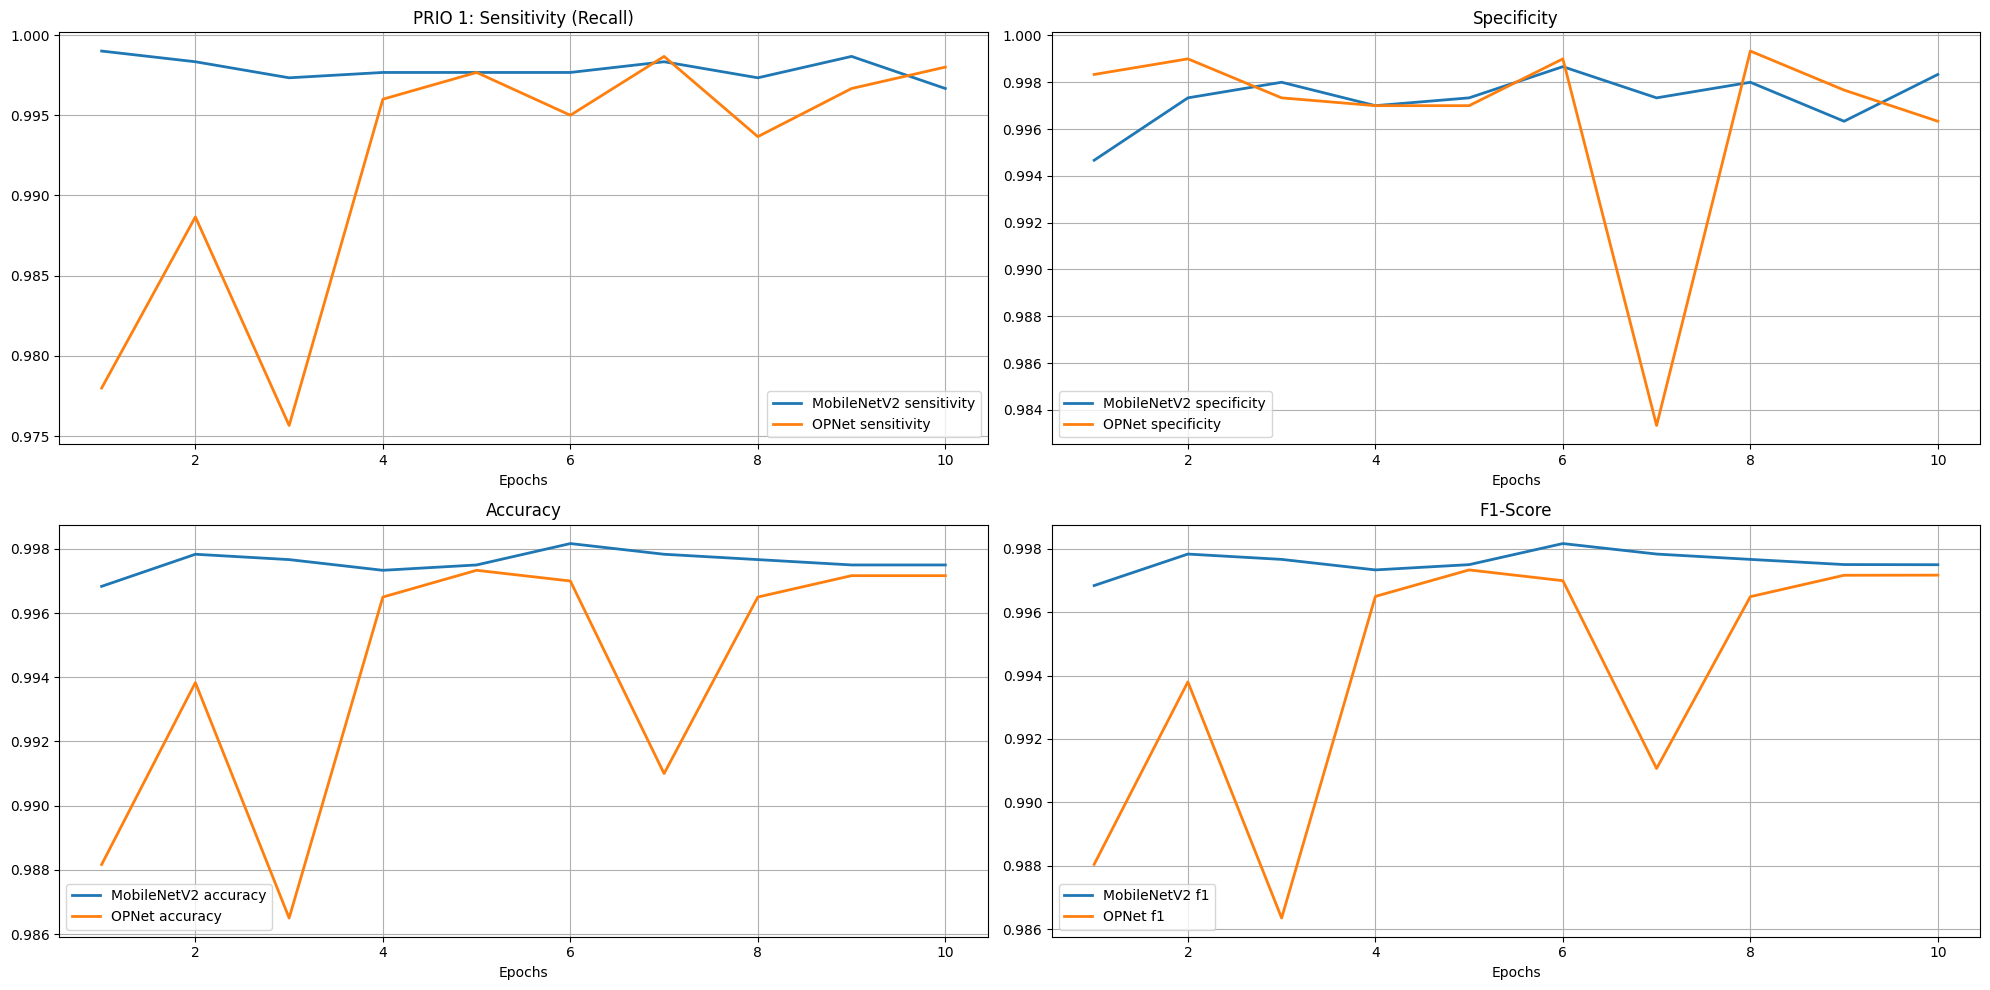

In [9]:
# =============================================================================
# 8. Training & Performance Analysis (Updated with Saving & Full Metrics)
# =============================================================================

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, f1_score
import time
import os

# --- 8.1. Setup Model Saving to Google Drive ---
MODEL_SAVE_DIR = "/content/drive/MyDrive/models"
if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR)
    print(f"Created model save directory: {MODEL_SAVE_DIR}")

# --- 8.2. Define the Master Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name="Model"):
    since = time.time()
    history = {
        'train_loss': [], 'val_loss': [],
        'val_sensitivity': [], 'val_specificity': [],
        'val_accuracy': [], 'val_f1': []
    }

    print(f"Starting training for {model_name}...")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        # --- Metrics Calculation ---
        val_epoch_loss = val_loss / len(val_loader.dataset)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        val_sensitivity = recall_score(all_labels, all_preds, zero_division=0) # Recall
        val_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)

        # Store results
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_epoch_loss)
        history['val_sensitivity'].append(val_sensitivity)
        history['val_specificity'].append(val_specificity)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {val_epoch_loss:.4f} | '
              f'SENS (Recall): {val_sensitivity:.4f} | Spec: {val_specificity:.4f} | '
              f'Acc: {val_accuracy:.4f} | F1: {val_f1:.4f}')

        # --- Save Epoch Checkpoint ---
        safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR, f"{safe_name}_epoch_{epoch+1}.pth"))

    print(f'{model_name} complete in {(time.time() - since) // 60:.0f}m')
    return history

# --- 8.3. Define Multi-Metric Plotting ---
def plot_comparison(h1, name1, h2, name2):
    epochs = range(1, len(h1['train_loss']) + 1)
    plt.figure(figsize=(20, 10))
    metrics = [('val_sensitivity', 'PRIO 1: Sensitivity (Recall)'), ('val_specificity', 'Specificity'),
               ('val_accuracy', 'Accuracy'), ('val_f1', 'F1-Score')]
    for i, (m, title) in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(epochs, h1[m], label=f'{name1} {m.split("_")[1]}', linewidth=2)
        plt.plot(epochs, h2[m], label=f'{name2} {m.split("_")[1]}', linewidth=2)
        plt.title(title); plt.xlabel('Epochs'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

# --- 8.4. EXECUTION: Baseline vs OPNet ---
from torchvision import datasets
BATCH_SIZE, NUM_EPOCHS, LR = 64, 10, 0.001

train_loader = DataLoader(datasets.ImageFolder(TRAIN_DIR, train_transforms), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(datasets.ImageFolder(VAL_DIR, val_test_transforms), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

criterion = nn.BCEWithLogitsLoss()

# Train MobileNetV2 Baseline
baseline_model = get_mobilenetv2_baseline(pretrained=True).to(device)
optimizer_b = optim.Adam(baseline_model.parameters(), lr=LR)
baseline_history = train_model(baseline_model, train_loader, val_loader, criterion, optimizer_b, NUM_EPOCHS, "MobileNetV2")

# Train OPNet Custom
opnet_model = OPNet().to(device)
optimizer_o = optim.Adam(opnet_model.parameters(), lr=LR)
opnet_history = train_model(opnet_model, train_loader, val_loader, criterion, optimizer_o, NUM_EPOCHS, "OPNet")

plot_comparison(baseline_history, "MobileNetV2", opnet_history, "OPNet")

In [10]:
# =============================================================================
# Execution: Run Experiments
# =============================================================================

# --- Configuration ---
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# --- 1. Define Datasets & DataLoaders ---
# Use the directories created in Step 2 and transforms from Step 4
from torchvision import datasets

train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=val_test_transforms)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# --- 2. Setup Baseline (MobileNetV2) ---
# Use the function from Step 6 to get MobileNetV2
baseline_model = get_mobilenetv2_baseline(pretrained=True).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=LEARNING_RATE)

# --- 3. Setup Custom Model (OPNet) ---
# Create a fresh instance of OPNet (defined in Step 7)
opnet_model = OPNet().to(device)
optimizer_opnet = optim.Adam(opnet_model.parameters(), lr=LEARNING_RATE)


# --- 4. Run Training (Experiment 8) ---

# A) Train Baseline (MobileNetV2)
print("\n--- Training Baseline: MobileNetV2 ---")
baseline_history = train_model(
    baseline_model, train_loader, val_loader, criterion, optimizer_baseline,
    num_epochs=NUM_EPOCHS, model_name="MobileNetV2"
)

# B) Train Custom Model (OPNet)
print("\n--- Training Custom Model: OPNet ---")
opnet_history = train_model(
    opnet_model, train_loader, val_loader, criterion, optimizer_opnet,
    num_epochs=NUM_EPOCHS, model_name="OPNet"
)

# --- 5. Compare Results (Experiment 8) ---
print("\n--- Comparing Baseline vs. Custom Model ---")
plot_comparison(baseline_history, "MobileNetV2", opnet_history, "OPNet")

Training samples: 28000
Validation samples: 6000

--- Training Baseline: MobileNetV2 ---
Starting training for MobileNetV2...
Epoch 1/10 | Loss: 0.0081 | SENS (Recall): 0.9973 | Spec: 0.9967 | Acc: 0.9970 | F1: 0.9970
Epoch 2/10 | Loss: 0.0104 | SENS (Recall): 0.9963 | Spec: 0.9983 | Acc: 0.9973 | F1: 0.9973
Epoch 3/10 | Loss: 0.0071 | SENS (Recall): 0.9970 | Spec: 0.9987 | Acc: 0.9978 | F1: 0.9978
Epoch 4/10 | Loss: 0.0102 | SENS (Recall): 0.9953 | Spec: 0.9987 | Acc: 0.9970 | F1: 0.9970


KeyboardInterrupt: 


=== Experiment 9a: Lower Learning Rate (1e-4) ===

--- Training MobileNetV2 (Low LR) ---
Starting training for MobileNetV2 (Low LR)...
Epoch 1/10 | Loss: 0.0068 | SENS (Recall): 0.9980 | Spec: 0.9980 | Acc: 0.9980 | F1: 0.9980
Epoch 2/10 | Loss: 0.0044 | SENS (Recall): 0.9993 | Spec: 0.9977 | Acc: 0.9985 | F1: 0.9985
Epoch 3/10 | Loss: 0.0039 | SENS (Recall): 0.9990 | Spec: 0.9987 | Acc: 0.9988 | F1: 0.9988
Epoch 4/10 | Loss: 0.0043 | SENS (Recall): 0.9993 | Spec: 0.9983 | Acc: 0.9988 | F1: 0.9988
Epoch 5/10 | Loss: 0.0056 | SENS (Recall): 0.9973 | Spec: 0.9993 | Acc: 0.9983 | F1: 0.9983
Epoch 6/10 | Loss: 0.0050 | SENS (Recall): 0.9980 | Spec: 0.9993 | Acc: 0.9987 | F1: 0.9987
Epoch 7/10 | Loss: 0.0060 | SENS (Recall): 0.9983 | Spec: 0.9983 | Acc: 0.9983 | F1: 0.9983
Epoch 8/10 | Loss: 0.0057 | SENS (Recall): 0.9987 | Spec: 0.9973 | Acc: 0.9980 | F1: 0.9980
Epoch 9/10 | Loss: 0.0050 | SENS (Recall): 0.9993 | Spec: 0.9973 | Acc: 0.9983 | F1: 0.9983
Epoch 10/10 | Loss: 0.0050 | SENS (R

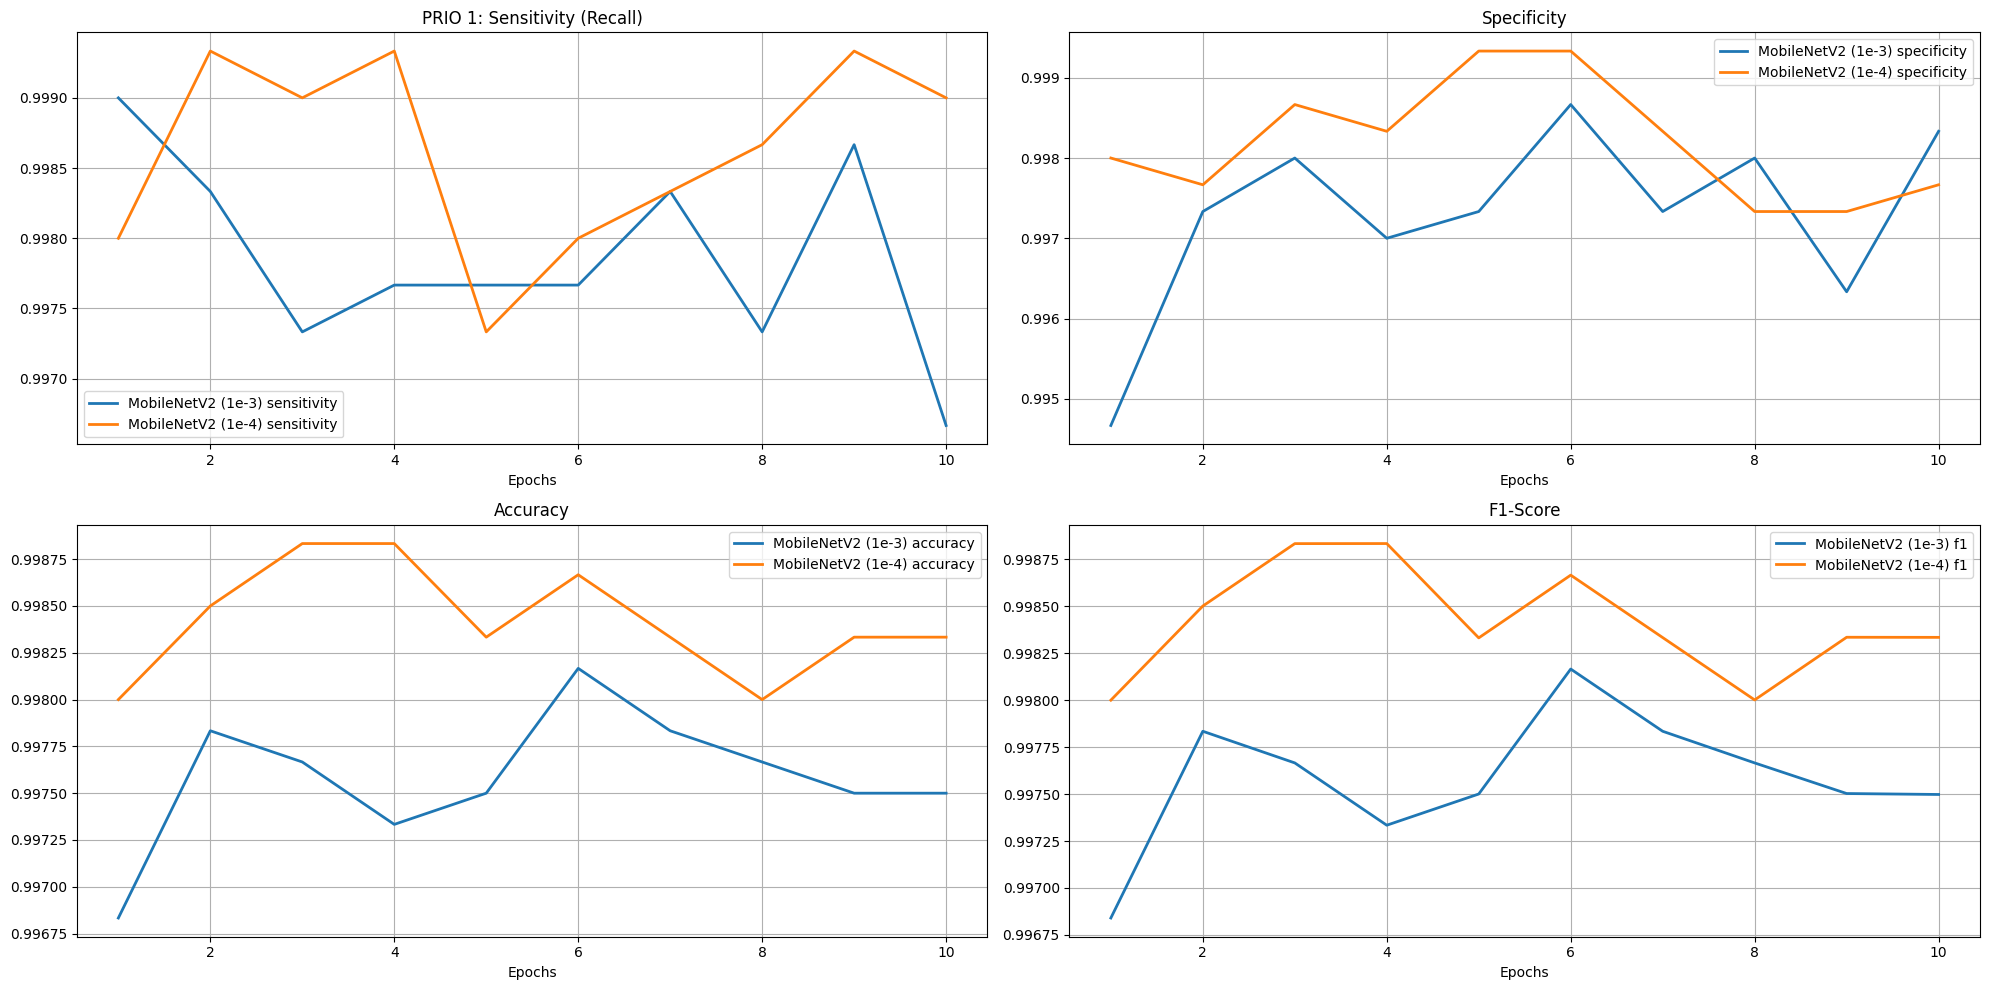


--- Comparison: OPNet LR Impact ---


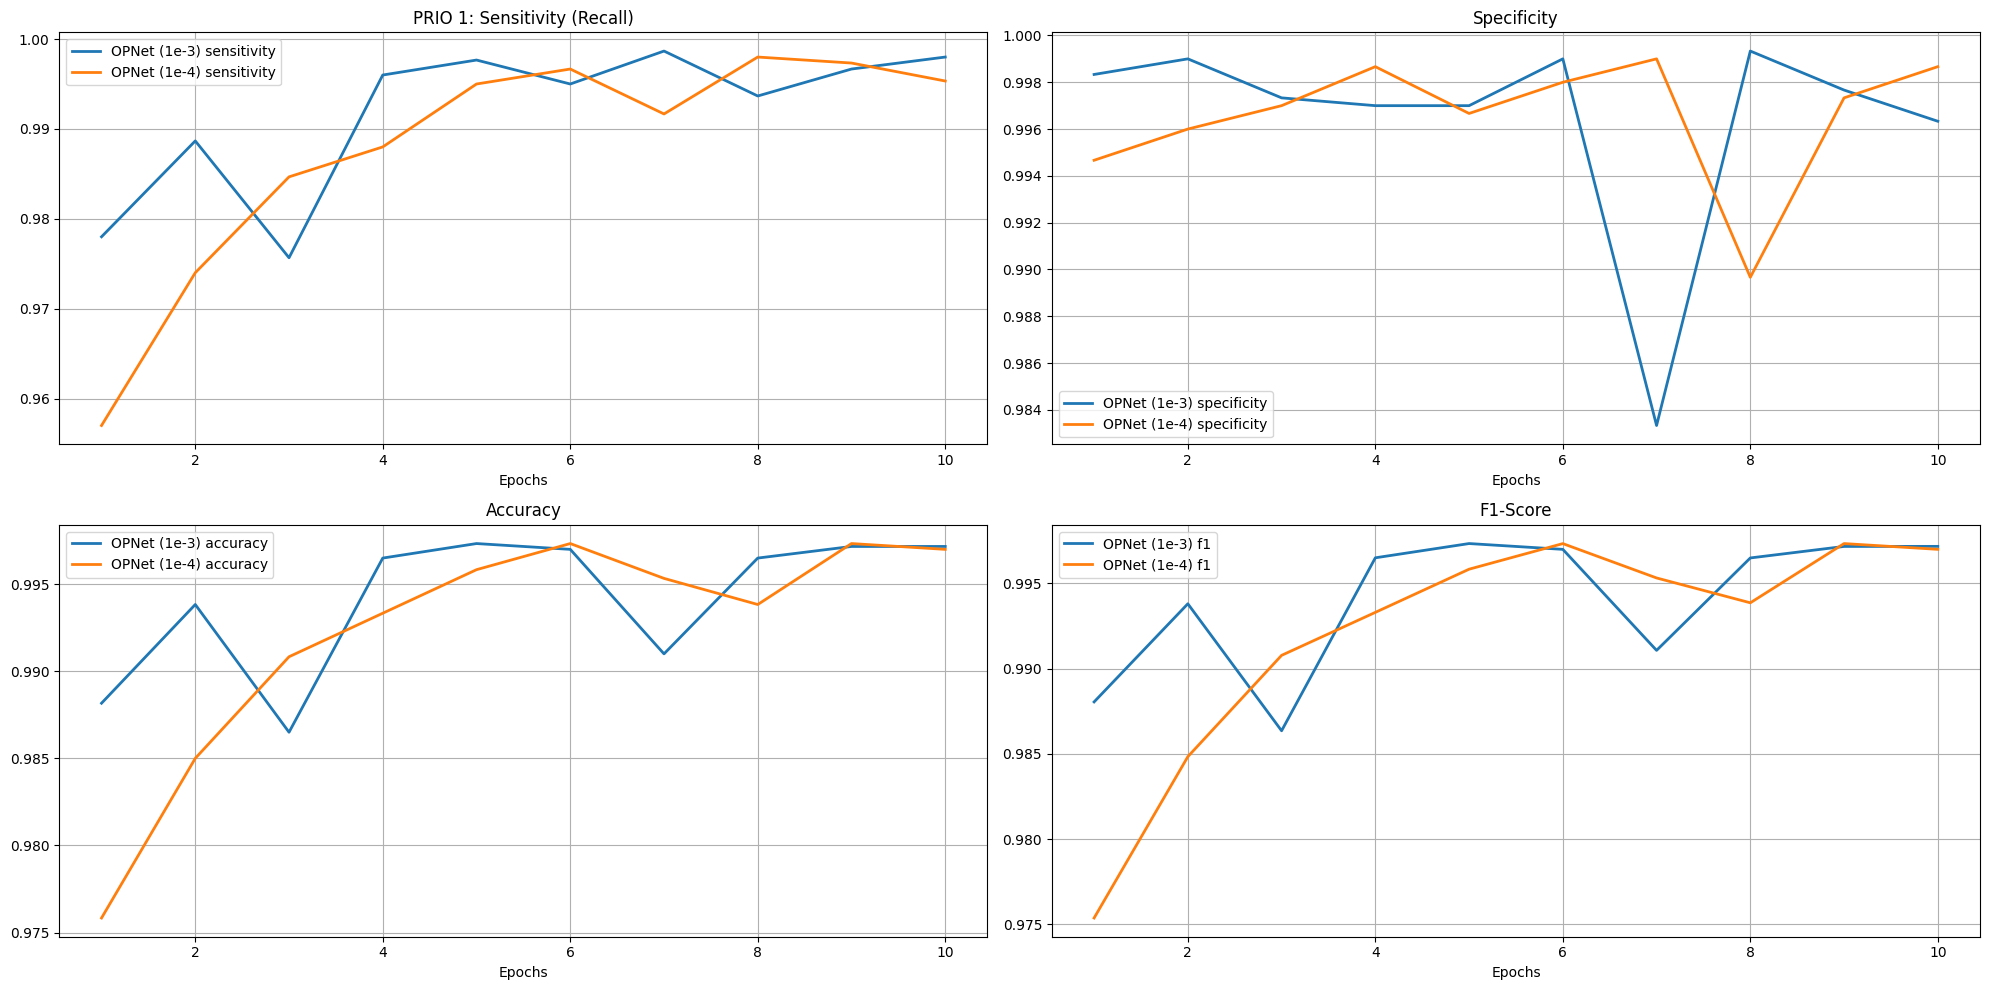

In [11]:
# =============================================================================
# 9a. Parameter Study: Learning Rate (Both Models)
# =============================================================================

print("\n=== Experiment 9a: Lower Learning Rate (1e-4) ===")
LR_LOW = 0.0001

# --- 1. Train Baseline with Low LR ---
print("\n--- Training MobileNetV2 (Low LR) ---")
# Fresh instance
baseline_low_lr = get_mobilenetv2_baseline(pretrained=True).to(device)
optimizer_base_low = optim.Adam(baseline_low_lr.parameters(), lr=LR_LOW)

baseline_low_lr_history = train_model(
    baseline_low_lr, train_loader, val_loader, criterion, optimizer_base_low,
    num_epochs=10, model_name="MobileNetV2 (Low LR)"
)

# --- 2. Train Custom OPNet with Low LR ---
print("\n--- Training OPNet (Low LR) ---")
# Fresh instance
opnet_low_lr = OPNet().to(device)
optimizer_op_low = optim.Adam(opnet_low_lr.parameters(), lr=LR_LOW)

opnet_low_lr_history = train_model(
    opnet_low_lr, train_loader, val_loader, criterion, optimizer_op_low,
    num_epochs=10, model_name="OPNet (Low LR)"
)

# --- 3. Comparisons ---

# Compare Baseline: Standard vs Low LR
print("\n--- Comparison: MobileNetV2 LR Impact ---")
plot_comparison(baseline_history, "MobileNetV2 (1e-3)", baseline_low_lr_history, "MobileNetV2 (1e-4)")

# Compare Custom: Standard vs Low LR
print("\n--- Comparison: OPNet LR Impact ---")
plot_comparison(opnet_history, "OPNet (1e-3)", opnet_low_lr_history, "OPNet (1e-4)")


=== Experiment 9b: Batch Size 32 ===

--- Training MobileNetV2 (Batch 32) ---
Starting training for MobileNetV2 (Batch 32)...
Epoch 1/10 | Loss: 0.0102 | SENS (Recall): 0.9957 | Spec: 0.9973 | Acc: 0.9965 | F1: 0.9965
Epoch 2/10 | Loss: 0.0114 | SENS (Recall): 0.9990 | Spec: 0.9937 | Acc: 0.9963 | F1: 0.9963
Epoch 3/10 | Loss: 0.0074 | SENS (Recall): 0.9980 | Spec: 0.9957 | Acc: 0.9968 | F1: 0.9968
Epoch 4/10 | Loss: 0.0086 | SENS (Recall): 0.9967 | Spec: 0.9983 | Acc: 0.9975 | F1: 0.9975
Epoch 5/10 | Loss: 0.0105 | SENS (Recall): 0.9990 | Spec: 0.9943 | Acc: 0.9967 | F1: 0.9967
Epoch 6/10 | Loss: 0.0097 | SENS (Recall): 0.9987 | Spec: 0.9963 | Acc: 0.9975 | F1: 0.9975
Epoch 7/10 | Loss: 0.0122 | SENS (Recall): 0.9953 | Spec: 0.9993 | Acc: 0.9973 | F1: 0.9973
Epoch 8/10 | Loss: 0.0089 | SENS (Recall): 0.9973 | Spec: 0.9980 | Acc: 0.9977 | F1: 0.9977
Epoch 9/10 | Loss: 0.0060 | SENS (Recall): 0.9967 | Spec: 0.9987 | Acc: 0.9977 | F1: 0.9977
Epoch 10/10 | Loss: 0.0080 | SENS (Recall): 0

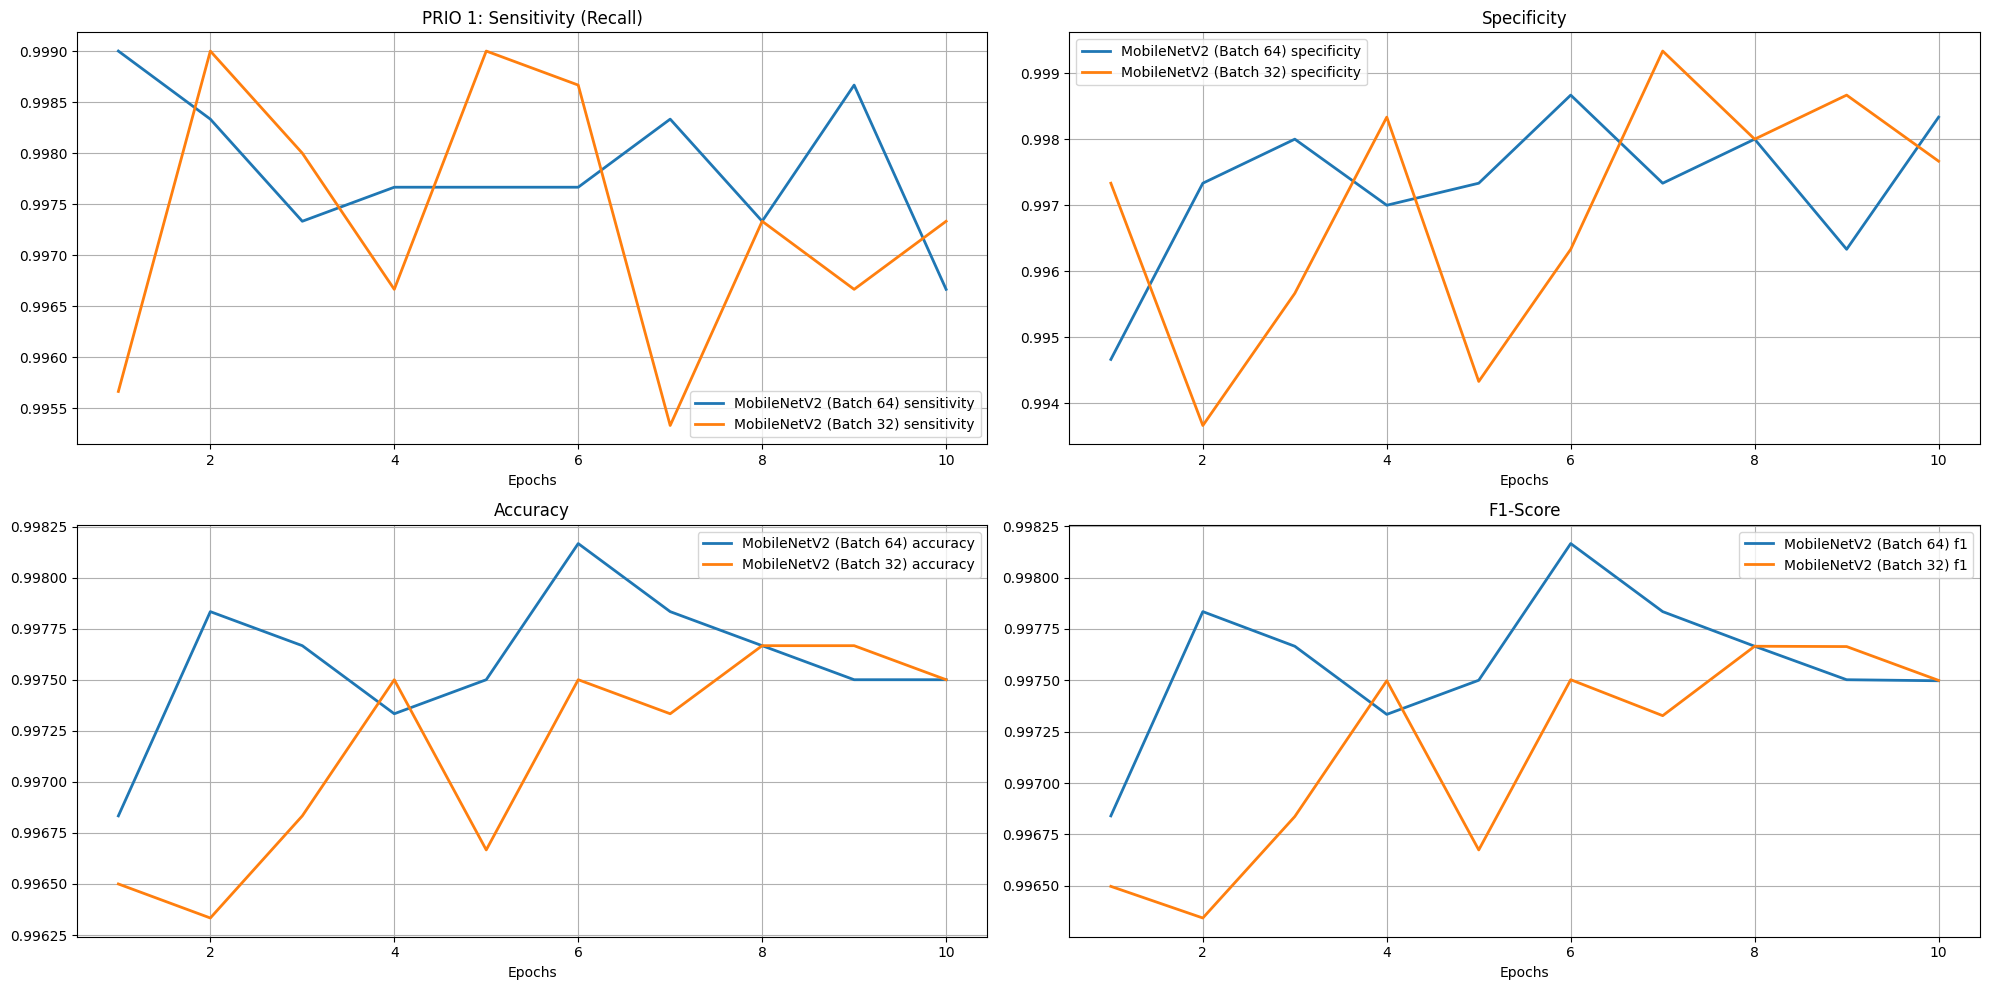


--- Comparison: OPNet Batch Size Impact ---


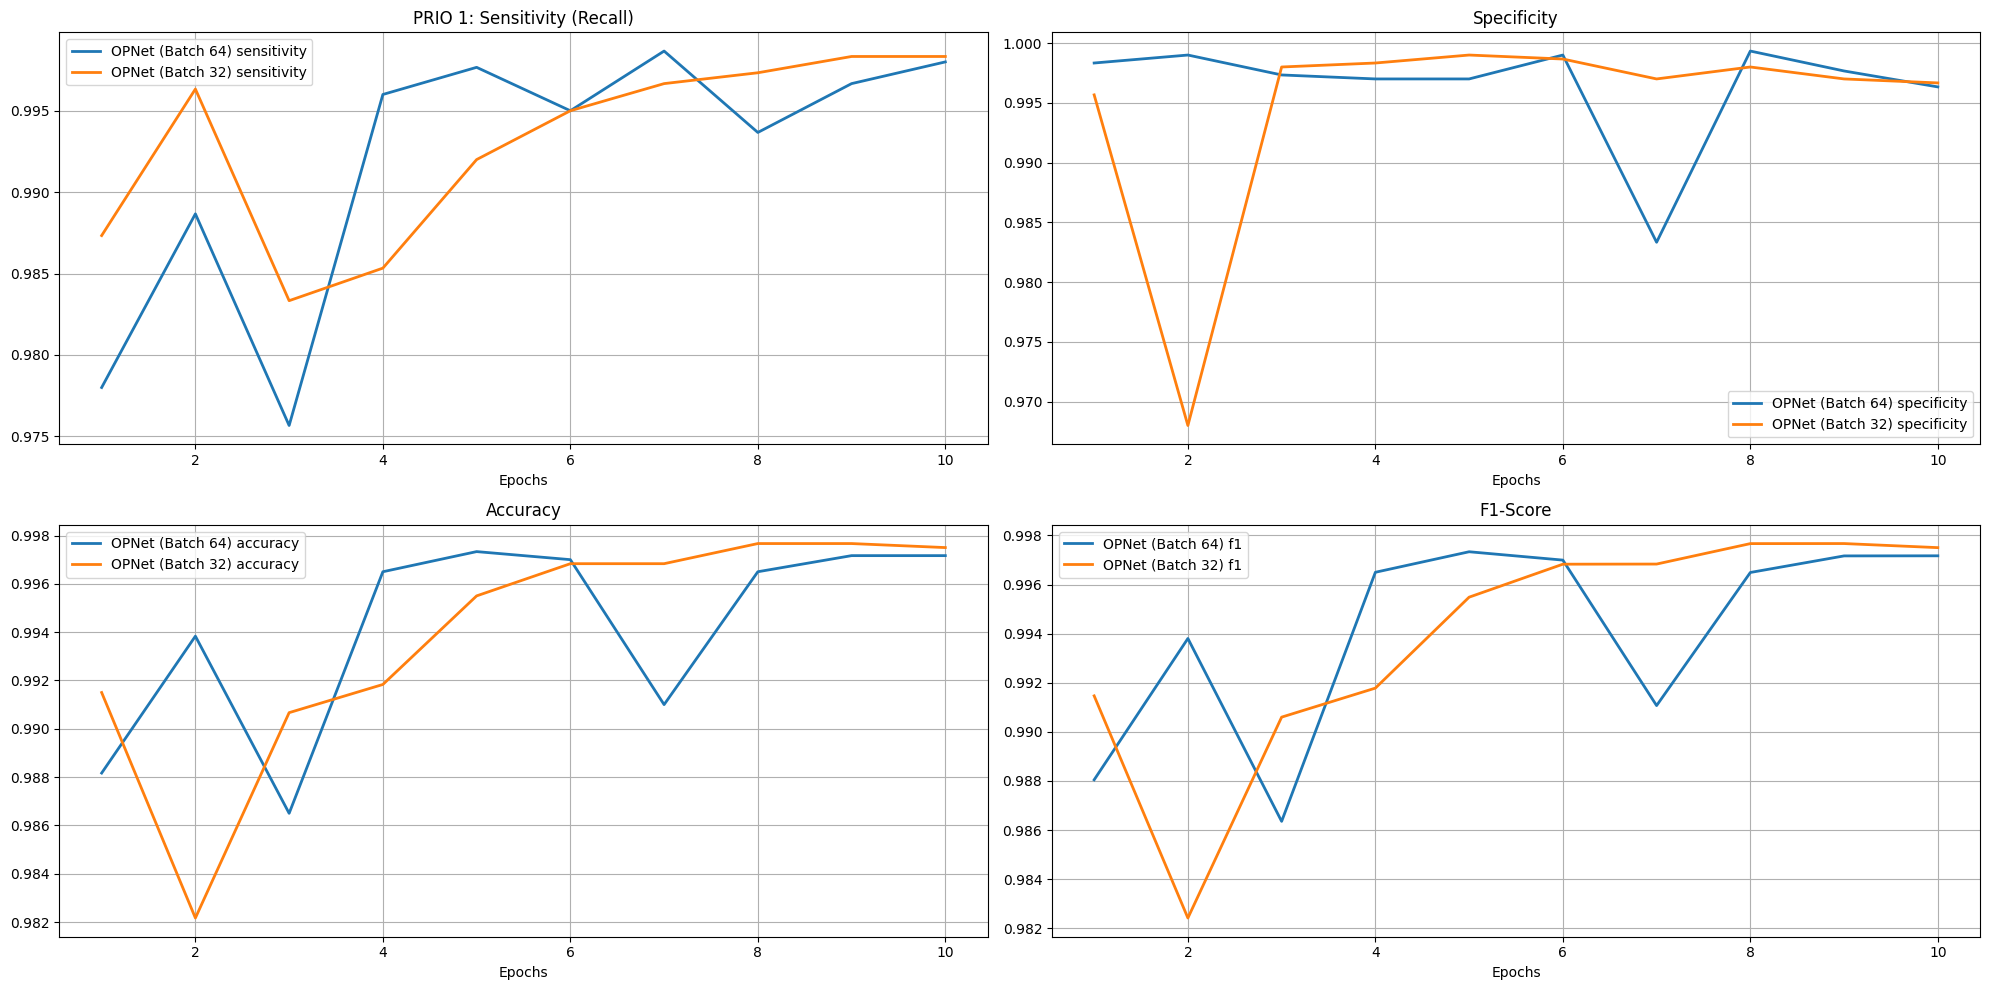

In [12]:
# =============================================================================
# 9b. Parameter Study: Batch Size 32 (Both Models)
# =============================================================================

print("\n=== Experiment 9b: Batch Size 32 ===")
BATCH_SIZE_EXP = 32

# 1. Create DataLoaders with Batch Size 32
train_loader_32 = DataLoader(datasets.ImageFolder(TRAIN_DIR, train_transforms),
                             batch_size=BATCH_SIZE_EXP, shuffle=True, num_workers=2)
val_loader_32 = DataLoader(datasets.ImageFolder(VAL_DIR, val_test_transforms),
                           batch_size=BATCH_SIZE_EXP, shuffle=False, num_workers=2)

# --- 2. Train Baseline with Batch 32 ---
print("\n--- Training MobileNetV2 (Batch 32) ---")
baseline_batch32 = get_mobilenetv2_baseline(pretrained=True).to(device)
# Use standard LR (1e-3) to isolate Batch Size effect
optimizer_base_b32 = optim.Adam(baseline_batch32.parameters(), lr=0.001)

baseline_batch32_history = train_model(
    baseline_batch32, train_loader_32, val_loader_32, criterion, optimizer_base_b32,
    num_epochs=10, model_name="MobileNetV2 (Batch 32)"
)

# --- 3. Train Custom OPNet with Batch 32 ---
print("\n--- Training OPNet (Batch 32) ---")
opnet_batch32 = OPNet().to(device)
optimizer_op_b32 = optim.Adam(opnet_batch32.parameters(), lr=0.001)

opnet_batch32_history = train_model(
    opnet_batch32, train_loader_32, val_loader_32, criterion, optimizer_op_b32,
    num_epochs=10, model_name="OPNet (Batch 32)"
)

# --- 4. Comparisons ---

# Compare Baseline: Batch 64 vs 32
print("\n--- Comparison: MobileNetV2 Batch Size Impact ---")
# baseline_history comes from Block 8 (Batch 64)
plot_comparison(baseline_history, "MobileNetV2 (Batch 64)", baseline_batch32_history, "MobileNetV2 (Batch 32)")

# Compare Custom: Batch 64 vs 32
print("\n--- Comparison: OPNet Batch Size Impact ---")
# opnet_history comes from Block 8 (Batch 64)
plot_comparison(opnet_history, "OPNet (Batch 64)", opnet_batch32_history, "OPNet (Batch 32)")

### **10. Error Analysis (5 Points)**

**Goal:** Identify *why* the model fails. We will find images where the model was wrong (False Positives & False Negatives) and display them. This allows us to hypothesize about the causes (e.g., shadows, weird textures).

In [16]:
# =============================================================================
# 10. Error Analysis: Visual Inspection (Best Models)
# =============================================================================

# --- 1. Load the Best Models from Drive ---
def load_best_model(model_class, model_name, epoch):
    print(f"Loading {model_name} from Epoch {epoch}...")

    # Re-instantiate architecture
    if model_name == "MobileNetV2":
        model = models.mobilenet_v2(weights=None) # No init weights needed, we load ours
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    elif model_name == "OPNet":
        model = OPNet() # Use class definition from earlier step

    model = model.to(device)

    # Load weights
    # Note: Filenames might differ slightly (e.g. spaces vs underscores).
    # Adjust path if your files are named differently.
    path = f"/content/drive/MyDrive/models/{model_name.replace(' ', '_')}_epoch_{epoch}.pth"

    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print("-> Success!")
    else:
        print(f"-> Error: File not found at {path}. Using untrained model (Results will be random!)")

    model.eval()
    return model

# Load based on our analysis (Best Epochs)
best_mobilenet = load_best_model(None, "MobileNetV2", epoch=6)
best_opnet = load_best_model(OPNet, "OPNet", epoch=9)


# --- 2. Find Misclassifications ---
def find_errors(model, loader, num=4):
    fps, fns = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.unsqueeze(1).float().to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            fp_idx = ((preds == 1) & (labels == 0)).nonzero(as_tuple=True)[0]
            fn_idx = ((preds == 0) & (labels == 1)).nonzero(as_tuple=True)[0]

            for i in fp_idx:
                if len(fps) < num: fps.append(inputs[i].cpu())
            for i in fn_idx:
                if len(fns) < num: fns.append(inputs[i].cpu())
            if len(fps) >= num and len(fns) >= num: break
    return fps, fns

print("\nSearching errors for MobileNetV2...")
mb_fps, mb_fns = find_errors(best_mobilenet, val_loader)

print("Searching errors for OPNet...")
op_fps, op_fns = find_errors(best_opnet, val_loader)


# --- 3. Visualize Side-by-Side ---
def show_comparison(images_mb, images_op, title):
    if len(images_mb) == 0 and len(images_op) == 0: return

    plt.figure(figsize=(15, 6))
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Show up to 4 images from MobileNet
    for i, img in enumerate(images_mb[:4]):
        img = inv_normalize(img).permute(1, 2, 0).numpy()
        plt.subplot(2, 4, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"MobileNet {title}")
        plt.axis('off')

    # Show up to 4 images from OPNet
    for i, img in enumerate(images_op[:4]):
        img = inv_normalize(img).permute(1, 2, 0).numpy()
        plt.subplot(2, 4, i+5)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"OPNet {title}")
        plt.axis('off')

    plt.suptitle(f"Comparison: {title}", fontsize=16)
    plt.tight_layout()
    plt.show()

show_comparison(mb_fps, op_fps, "False Positives")
show_comparison(mb_fns, op_fns, "False Negatives")

Loading MobileNetV2 from Epoch 6...


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### **11. Bonus: Explainability / Grad-CAM (+5 Points)**

**Goal:** Visualize *where* the model is looking. Grad-CAM (Gradient-weighted Class Activation Mapping) erzeugt eine Heatmap, die über das Bild gelegt wird. Rote Bereiche zeigen an, welche Pixel für die Entscheidung "Riss" am wichtigsten waren.

In [3]:
# =============================================================================
# 11. Explainability: Grad-CAM Comparison
# =============================================================================

# --- 1. Robust Grad-CAM Class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        # Hooks
        self.h1 = target_layer.register_forward_hook(self.save_activation)
        self.h2 = target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output): self.activations = output
    def save_gradient(self, module, grad_in, grad_out): self.gradients = grad_out[0]
    def remove(self): self.h1.remove(); self.h2.remove()

    def __call__(self, x):
        output = self.model(x)
        score = output[:, 0]
        self.model.zero_grad()
        score.backward(retain_graph=True)

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.nn.functional.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        return cam.detach().cpu().numpy()

# --- 2. Setup Grad-CAM for Both Models ---
# MobileNet Target: Last layer of 'features' block
cam_mobilenet = GradCAM(best_mobilenet, best_mobilenet.features[-1])

# OPNet Target: Last conv layer (block4)
# Note: block4 is a Sequential. We need the CONV layer inside it (index 0).
cam_opnet = GradCAM(best_opnet, best_opnet.block4[0])


# --- 3. Visualization Function ---
def plot_gradcam_compare(images, cam_obj, model_name, title):
    if len(images) == 0: return

    plt.figure(figsize=(15, 4))
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    for i, img_tensor in enumerate(images[:4]):
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad = True

        # Generate Heatmap
        mask = cam_obj(input_tensor)[0, 0]
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-7) # Normalize per image

        img = inv_normalize(img_tensor).permute(1, 2, 0).numpy()

        plt.subplot(1, 4, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.imshow(mask, alpha=0.5, cmap='jet')
        plt.title(f"{model_name} Error {i+1}")
        plt.axis('off')

    plt.suptitle(f"Explainability ({model_name}): {title}", fontsize=16)
    plt.show()

# --- 4. Generate Plots ---
print("--- MobileNetV2 Explainability ---")
plot_gradcam_compare(mb_fps, cam_mobilenet, "MobileNetV2", "False Positives")
plot_gradcam_compare(mb_fns, cam_mobilenet, "MobileNetV2", "False Negatives")

print("\n--- OPNet Explainability ---")
plot_gradcam_compare(op_fps, cam_opnet, "OPNet", "False Positives")
plot_gradcam_compare(op_fns, cam_opnet, "OPNet", "False Negatives")

# Cleanup
cam_mobilenet.remove()
cam_opnet.remove()

NameError: name 'baseline_model' is not defined